In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class GammaNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(GammaNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        alpha_components = F.softplus(x[:, :, 0])
        beta_components = F.softplus(x[:, :, 1])

        alpha = torch.sum(alpha_components, dim=1).unsqueeze(dim=1) + 1e-10
        beta = torch.sum(beta_components, dim=1).unsqueeze(dim=1) + 1e-10

        if self.use_intercept:
            alpha = alpha + F.softplus(self.intercept[0])
            beta = beta + F.softplus(self.intercept[1])

        return alpha, beta

    def nll_loss(self, alpha, beta, y_true, robustness_factor=None):
        gamma_dist = dist.Gamma(alpha, beta)
        # log_likelihood = gamma_dist.log_prob(y_true).sum()
        log_likelihood = gamma_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            # log_likelihood = torch.log((1 + torch.exp(gamma_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).sum()
            log_likelihood = torch.log((1 + torch.exp(gamma_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean()

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val = None, y_val = None, n_epochs = 10000, lr = 1e-3, weight_decay = 0.0, 
            early_stopping_patience = 10, robustness_factor = None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            alpha, beta = self.forward(X_train)
            train_loss = self.nll_loss(alpha, beta, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    alpha_val, beta_val = self.forward(X_val)
                    val_loss = self.nll_loss(alpha_val, beta_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                # print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                pass

        return self
    
    def predict(self, x):
        alpha, beta = self.forward(x)

        alpha = alpha.detach()
        beta = beta.detach()

        return alpha, beta
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            alpha_components = F.softplus(x[:, :, 0]).detach().cpu().numpy()
            beta_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()

            mean_components = alpha_components * beta_components
            variance_components = alpha_components * beta_components ** 2

        return mean_components, variance_components

- mean = alpha * beta
- variance = alpha * beta^2

--> 
- alpha = mean^2/variance
- beta = variance/mean

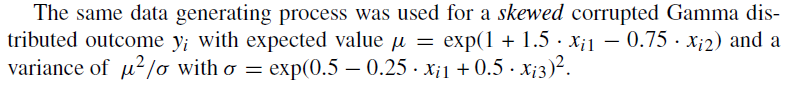

In [8]:
import torch

test = torch.tensor([1,2,3,4,5,6,7,8,9,10,11], dtype = torch.float32)

In [9]:
torch.quantile(test, 0.1)

tensor(2.)

In [15]:
for i in range(0,5):
    print(i)

0
1
2
3
4
